# SCEPTR UMAP 2D Visualization

This notebook loads a single best-epoch SCEPTR model checkpoint, computes a bag-level embedding (the sparse-attention weighted sum), and then visualizes those embeddings in a 2D space using UMAP. We'll plot control vs. cancer patients in different colors.


In [43]:
import os
import sys
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# from umap import umap_ as UMAP  # Make sure you've installed umap-learn
import umap.umap_ as umap

import warnings
warnings.filterwarnings("ignore")

# If your code is in a subfolder, adjust sys.path accordingly:
# sys.path.append(str(Path.cwd() / "src"))

from src.model import sceptr_unidirectional, load_trained
import sceptr  # from pip install sceptr

plt.rcParams["figure.figsize"] = (10, 8)
sns.set_style("whitegrid")

## 1. Configuration
- Specify which model checkpoint to load.
- Define paths to evaluation data (`data/beta/sceptr-eval`).


In [44]:
# ---- Adjust these paths to match your best checkpoint setup ----

# Suppose you have best run index = 0, best epoch = 33 (as in your example).
BEST_RUN_INDEX = 0
BEST_EPOCH = 33

# Path to the directory that stores your model checkpoint:
model_dir = Path.cwd() / "results-new-beta" / "sceptr" / f"trained-sceptr-{BEST_RUN_INDEX}" / f"Epoch {BEST_EPOCH}"
model_path = model_dir / f"classifier-{BEST_EPOCH}.pth"

# BEST_RUN_INDEX = 4
# BEST_EPOCH = 49

# model_dir = Path.cwd() / "results" / "sceptr" / f"trained-sceptr-caneval-{BEST_RUN_INDEX}" / f"Epoch {BEST_EPOCH}"
# model_path = model_dir / f"classifier-{BEST_EPOCH}.pth"

eval_dir = Path.cwd() / "data" / "beta" / "sceptr-eval"
control_dir = eval_dir / "control"
cancer_dir = eval_dir / "pbmc_cancer"

print(f"Model path: {model_path}")
print(f"Control dir: {control_dir}")
print(f"Cancer dir: {cancer_dir}")

Model path: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-0/Epoch 33/classifier-33.pth
Control dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/beta/sceptr-eval/control
Cancer dir: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/data/beta/sceptr-eval/pbmc_cancer


## 2. Load the Model
We’ll load the trained `sceptr_unidirectional` classifier. We’re primarily interested in the *aggregated bag vector*, which is computed in the forward pass by taking `model.last_weights * embeddings` and summing. We’ll replicate that logic below to extract each patient’s final 64‐dim vector.


In [45]:
# Load the trained model
model = load_trained(
    path_to_trained=model_path,
    hypothesised_model=sceptr_unidirectional
)
# Put model in eval mode
model.eval()
print("Loaded model:", model_path)
if torch.cuda.is_available():
    model.cuda()

Loaded model: /cs/student/ug/2022/jpytel/Documents/fyp/TCR-Cancer-Prediction/results-new-beta/sceptr/trained-sceptr-0/Epoch 33/classifier-33.pth


## 3. Helper Function: Get Bag Vector
We’ll define a little function that:
1. Takes a dataframe of TCR sequences (CDR3, V calls, etc.).
2. Uses `sceptr.calc_vector_representations()` to get a `[N,64]` embedding.
3. Feeds it into our model’s sparsemax aggregator.
4. Returns that single `[1,64]` bag vector.


In [46]:
def get_bag_vector_from_df(df: pd.DataFrame, model: sceptr_unidirectional):
    """
    Given a DataFrame of TCR sequences (with columns suitable for sceptr.calc_vector_representations()),
    returns the single bag-level vector (shape [1, 64]) from the model's aggregator.
    """
    # Step 1: Convert to embedding using SCEPTR
    embeddings = sceptr.calc_vector_representations(df)
    embeddings_t = torch.from_numpy(embeddings).float()
    if torch.cuda.is_available():
        embeddings_t = embeddings_t.cuda()

    # Step 2: Forward pass (but we want the aggregator, so we replicate part of forward)
    with torch.no_grad():
        _ = model(embeddings_t)  # model.forward() sets model.last_scores, model.last_weights

        # Weighted sum
        # model.last_weights shape: [N,1]
        # embeddings_t shape: [N,64]
        bag_vec = model.last_weights * embeddings_t
        bag_vec = bag_vec.sum(dim=0, keepdim=True)  # shape [1,64]
    return bag_vec.cpu().numpy()


## 4. Collect All Patient Bag Vectors
We’ll read every `*.tsv` file from `control` and `pbmc_cancer`. Each file presumably corresponds to **one patient** (the “bag”). Then we:
- compute the `[1,64]` bag vector,
- store it in an array,
- store the label (0=control, 1=cancer)
- store the path or some ID for plotting.


In [47]:
control_files = sorted(control_dir.glob("*.tsv"))
cancer_files = sorted((cancer_dir).glob("*.tsv"))

bag_vectors = []  # list of shape [1,64]
labels = []       # 0 or 1
patient_ids = []  # str of filename or something

print("Processing control files...")
for f in tqdm(control_files):
    df = pd.read_csv(f, sep="\t")
    vec = get_bag_vector_from_df(df, model)
    bag_vectors.append(vec)
    labels.append(0)
    patient_ids.append(f.stem)

print("Processing cancer files...")
for f in tqdm(cancer_files):
    df = pd.read_csv(f, sep="\t")
    vec = get_bag_vector_from_df(df, model)
    bag_vectors.append(vec)
    labels.append(1)
    patient_ids.append(f.stem)

bag_vectors = np.concatenate(bag_vectors, axis=0)  # shape [num_patients, 64]
labels = np.array(labels)
patient_ids = np.array(patient_ids)

print("Bag vectors shape:", bag_vectors.shape)
print("Labels shape:", labels.shape)

Processing control files...


100%|██████████| 22/22 [00:38<00:00,  1.73s/it]


Processing cancer files...


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]

Bag vectors shape: (33, 64)
Labels shape: (33,)


## 5. Apply UMAP
UMAP will reduce our `[num_patients, 64]` matrix to `[num_patients, 2]`. We can then scatter‐plot.


In [48]:
# Fit UMAP (or MDS, or t-SNE if you prefer)
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
coords_2d = umap_reducer.fit_transform(bag_vectors)

print("2D coords shape:", coords_2d.shape)

2D coords shape: (33, 2)


## 6. Plot the 2D Scatter
We’ll color 0=control in one color, 1=cancer in another color.  You can label or annotate points if you like.  We’ll keep it simple.


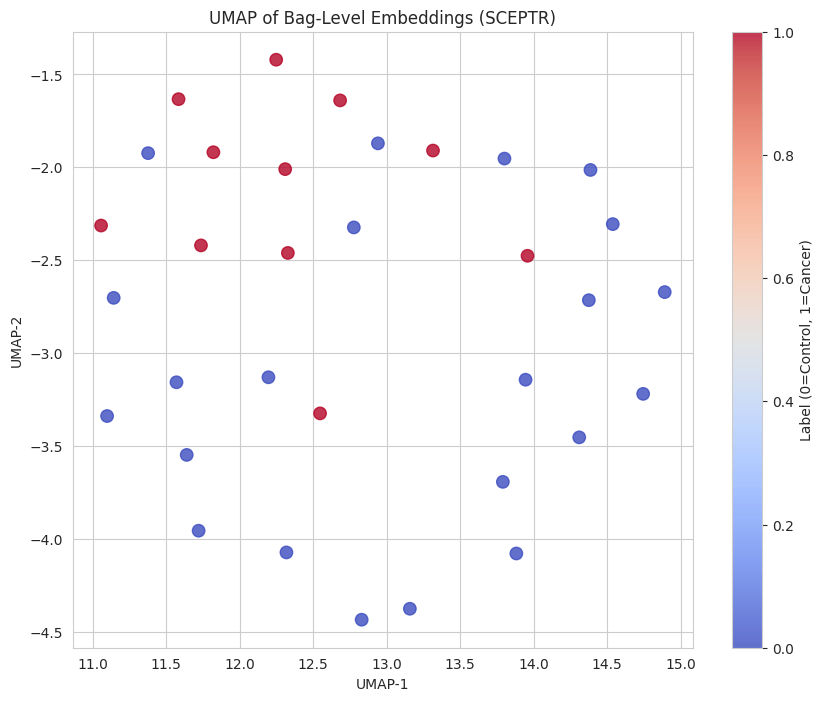

In [49]:
# Quick scatter:
plt.figure(figsize=(10,8))
scatter = plt.scatter(
    coords_2d[:,0], coords_2d[:,1],
    c=labels, cmap="coolwarm", alpha=0.8, s=80
)
plt.colorbar(scatter, label="Label (0=Control, 1=Cancer)")
plt.title("UMAP of Bag-Level Embeddings (SCEPTR)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

### Optional: If you want a fancy plot with seaborn
Here’s how you might do it if you wanted a legend with discrete categories:


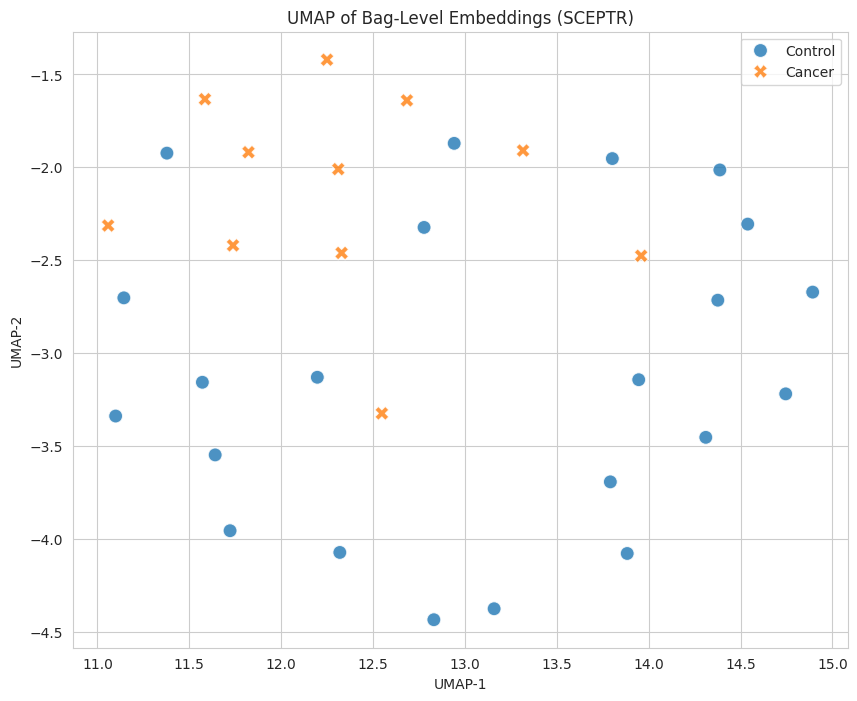

In [50]:
df_plot = pd.DataFrame({
    'x': coords_2d[:,0],
    'y': coords_2d[:,1],
    'label': labels,
    'patient_id': patient_ids
})
# We'll label 0=Control, 1=Cancer
df_plot['diagnosis'] = df_plot['label'].map({0: 'Control', 1: 'Cancer'})

plt.figure(figsize=(10,8))
sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='diagnosis',
    style='diagnosis',  # or style=patient_id if you want many shapes
    s=100,  # point size
    alpha=0.8
)
plt.title("UMAP of Bag-Level Embeddings (SCEPTR)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.show()


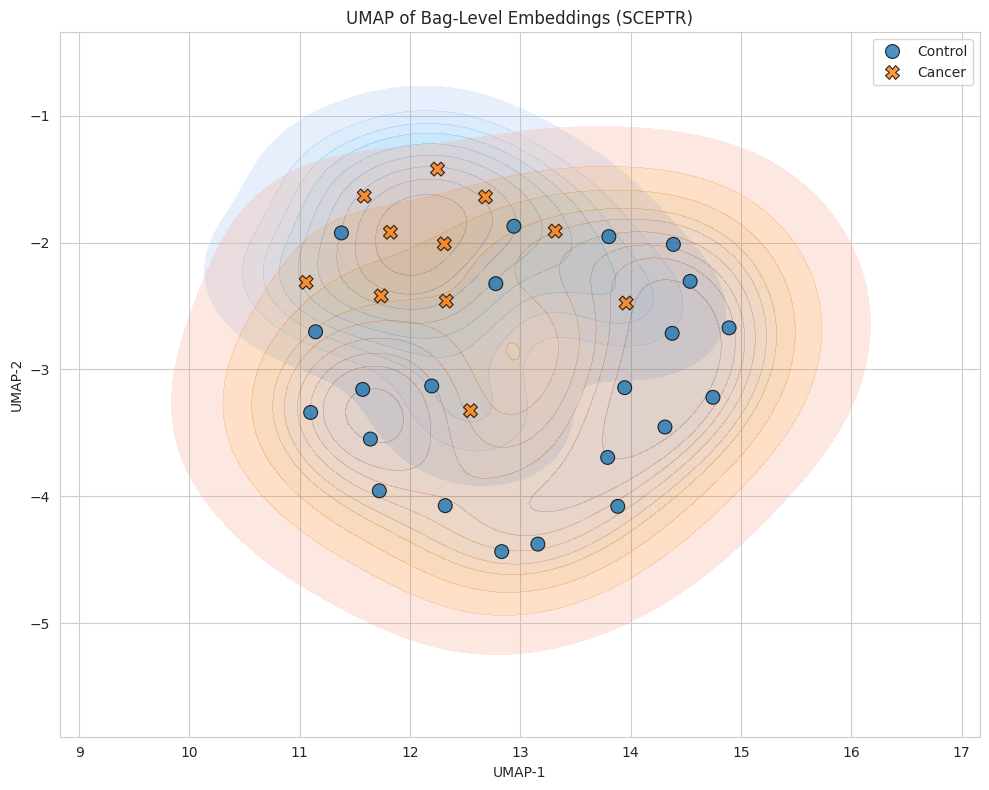

In [51]:
plt.figure(figsize=(10, 8))

# First, plot KDEs (shaded regions)
for label, group in df_plot.groupby('diagnosis'):
    sns.kdeplot(
        x=group['x'],
        y=group['y'],
        fill=True,
        alpha=0.25,
        linewidth=1.5,
        label=f"{label} Region",
    )

# Then, plot points
sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='diagnosis',
    style='diagnosis',
    s=100,
    alpha=0.8,
    edgecolor='black'
)

plt.title("UMAP of Bag-Level Embeddings (SCEPTR)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Observations
See if control vs. cancer lumps into distinct clusters. If they do, that suggests the model learned a strong latent separation. If not, they might be more intermixed.


### Next Steps
 - You could try coloring by the *model’s predicted probability*, or a separate dimension.
 - You could also see how it differs for different best epochs or different runs.
 - If you prefer MDS: from `sklearn.manifold import MDS` then do `coords_2d = MDS(n_components=2).fit_transform(bag_vectors)`.
